In [36]:
import os
from nilearn import plotting

bids_path = '/DATAPOOL/MUSICNF/BIDS-MUSICNF'
backup_folder = '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sourcedata/bidsonym'
sub_id = '01'

In [37]:
bidsonym_cmd = f'docker run --rm \
    -v {bids_path}:/bids_dataset \
    peerherholz/bidsonym /bids_dataset participant \
    --participant_label {sub_id} \
    --deid pydeface \
    --brainextraction bet \
    --bet_frac 0.5 \
    --skip_bids_validation'

In [38]:
# run the command
os.system(bidsonym_cmd)

Some packages in this Docker container are non-free
If you are considering commercial use of this container, please consult the relevant license:
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Licence
Input data will not be checked for BIDS compliance.
Found the following session(s) for participant 01:
[]
250204-15:29:45,239 nipype.workflow INFO:
	 Workflow brainextraction_wf settings: ['check', 'execution', 'logging', 'monitoring']
250204-15:29:45,245 nipype.workflow INFO:
	 Running serially.
250204-15:29:45,245 nipype.workflow INFO:
	 [Node] Setting-up "brainextraction_wf.bet" in "/tmp/tmp07pn9288/brainextraction_wf/bet".
250204-15:29:45,249 nipype.workflow INFO:
	 [Node] Executing "bet" <nipype.interfaces.fsl.preprocess.BET>
250204-15:29:52,582 nipype.workflow INFO:
	 [Node] Finished "bet", elapsed time 7.317833s.
the following meta-data files will be checked:
/bids_dataset/participants.json
/bids_dataset/dataset_description.json
/bids_dataset/sub-01/anat/sub-01_T1w.json
/bids_dataset/sub-0

0

## Check output

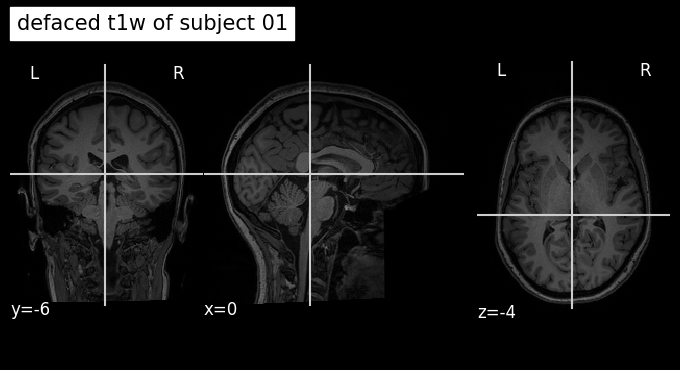

In [39]:
t1w_defaced = f'{bids_path}/sub-{sub_id}/anat/sub-{sub_id}_T1w.nii.gz'

plotting.plot_anat(t1w_defaced, title = f'defaced t1w of subject {sub_id}')

## Deface T2w
There is curently a bug in bidsonym that fails to identify the T2w image. This is a workaround.

In [38]:
# change folder permissions (manually)
f'sudo chmod -R g+rwx {backup_folder}/sub-{sub_id}'

'sudo chmod -R g+rwx /DATAPOOL/MUSICNF/BIDS-MUSICNF/sourcedata/bidsonym/sub-05'

In [40]:
# backup the original T2w image
os.system(f'cp {bids_path}/sub-{sub_id}/anat/sub-{sub_id}_T2w.nii.gz {backup_folder}/sub-{sub_id}/sub-{sub_id}_T2w.nii.gz')

0

In [41]:
# use the defaced T1w image as the mask for the T2w
t2w = f'{bids_path}/sub-{sub_id}/anat/sub-{sub_id}_T2w.nii.gz'

# use fslmaths to apply the mask
fslmaths_cmd = f'fslmaths {t2w} -mas {t1w_defaced} {t2w}'

os.system(fslmaths_cmd)

0

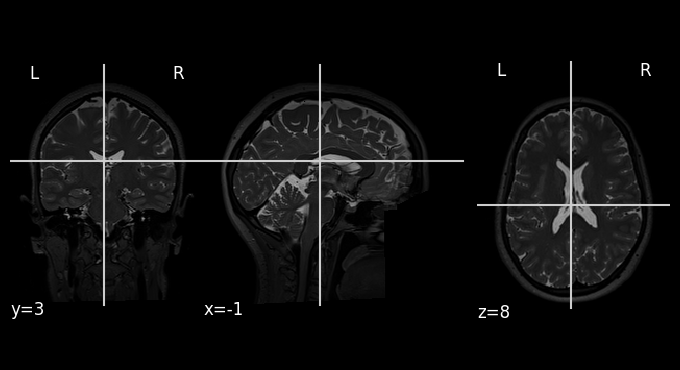

In [42]:
# view image using nilearn
plotting.plot_anat(t2w)

# Trim JSONs
Remove these fields: InstitutionName, InstitutionalDepartmentName, InstitutionAddress, DeviceSerialNumber, StationName

In [45]:
# search all jsons inside bids folder into a list
jsons = []
for root, dirs, files in os.walk(bids_path):
    # exclude derivatives folder
    if 'derivatives' not in root:
        for file in files:
            if file.endswith('.json') and file.startswith('sub-'):
                jsons.append(os.path.join(root, file))

jsons


['/DATAPOOL/MUSICNF/BIDS-MUSICNF/sub-16/anat/sub-16_T1w.json',
 '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sub-16/anat/sub-16_T2w.json',
 '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sub-16/fmap/sub-16_magnitude2.json',
 '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sub-16/fmap/sub-16_phasediff.json',
 '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sub-16/fmap/sub-16_magnitude1.json',
 '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sub-16/func/sub-16_task-loc_run-1_bold.json',
 '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sub-16/func/sub-16_task-sham_run-2_bold.json',
 '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sub-16/func/sub-16_task-sham_run-1_bold.json',
 '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sub-16/func/sub-16_task-nf_run-1_bold.json',
 '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sub-16/func/sub-16_task-nf_run-2_bold.json',
 '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sub-05/func/sub-05_task-loc_run-1_bold.json',
 '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sub-05/func/sub-05_task-sham_run-2_bold.json',
 '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sub-05/func/sub-05_task-nf_run-1_bold.json',
 '/DATAPOOL/MUSICNF/BIDS-MUSICNF/

In [47]:
# open each json file and remove the followings field if they exist: InstitutionName, InstitutionalDepartmentName, InstitutionAddress, DeviceSerialNumber, StationName
import json

for json_file in jsons:
    with open(json_file, 'r') as f:
        data = json.load(f)

    if 'InstitutionName' in data:
        del data['InstitutionName']
    if 'InstitutionalDepartmentName' in data:
        del data['InstitutionalDepartmentName']
    if 'InstitutionAddress' in data:
        del data['InstitutionAddress']
    if 'DeviceSerialNumber' in data:
        del data['DeviceSerialNumber']
    if 'StationName' in data:
        del data['StationName']

    with open(json_file, 'w') as f:
        json.dump(data, f, indent=4)